In [1]:
import subprocess
import json
from scipy.stats import beta, linregress, norm
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd
import numpy as np

In [2]:
a_, b_ = 2, 5
ugd_associated_ratings = [0.69,0.73,0.71,0.65,0.52,0.48,0.44]
loc = min(ugd_associated_ratings)
scale = max(ugd_associated_ratings) - min(ugd_associated_ratings)
credit_score = beta.rvs(a_, b_, loc=loc, scale=scale)
# exposure_at_default = money_already_lent + (commitment * credit_score)

In [3]:
company_financials = pd.read_csv('accounts_07798925_20210202100134.csv')
company_financials = company_financials.drop(['Attributes'], axis=1)
total_assets = company_financials.loc['Total Current Assets']
total_assets = [int(x) for x in total_assets.iloc[0].name][::-1]
x = np.linspace(1, len(total_assets), len(total_assets))
normalised_total_assets = preprocessing.normalize(np.array(total_assets).reshape(1,7))

In [4]:
company_value = 43.1 * 1000000

In [5]:
growth, _, _, _, _, = linregress(x, np.array(normalised_total_assets).reshape(7,))
expected_return = growth
volatility = np.std(normalised_total_assets)

Text(0.5, 1.0, 'Total Current Asset for the past 7 years')

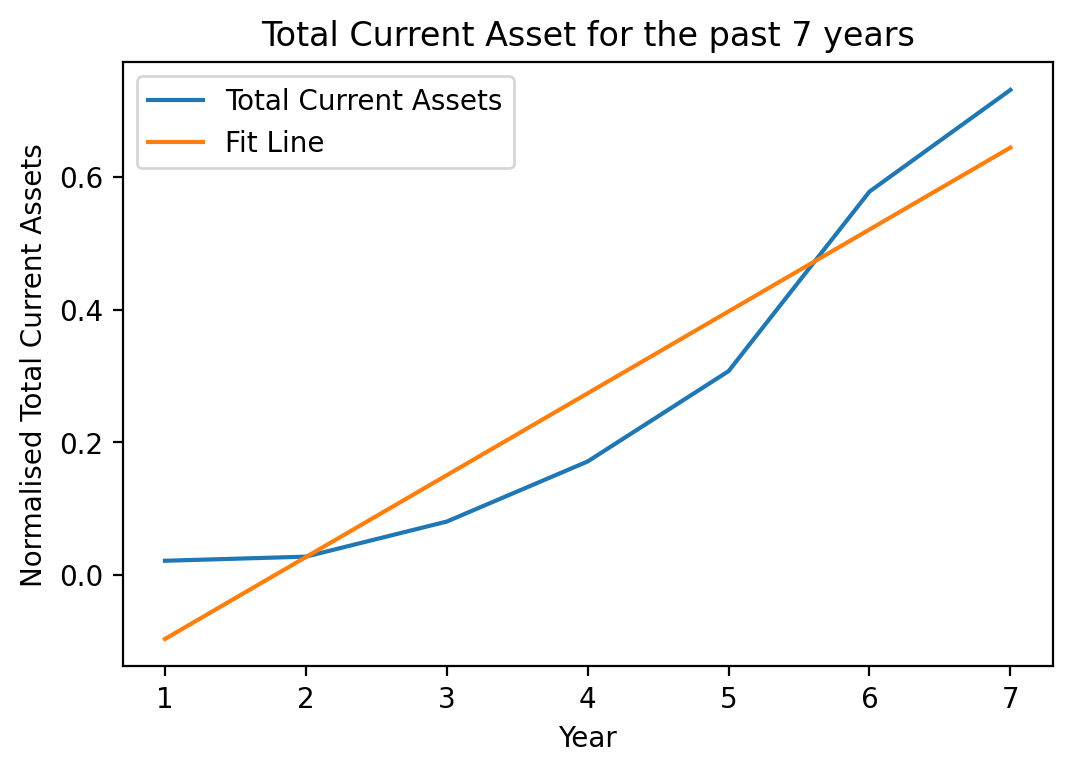

In [6]:
m, b = np.polyfit(x, normalised_total_assets.reshape(7,), 1)
plt.figure(figsize=(6,4), dpi=200)
plt.plot(x, normalised_total_assets.reshape(7,), label='Total Current Assets')
plt.plot(x, m*x+b, label='Fit Line')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Normalised Total Current Assets')
plt.title('Total Current Asset for the past {} years'.format(len(total_assets)))

In [7]:
short_term_liability = company_financials.loc['Total Current Liabilities']
short_term_liability = int(short_term_liability.iloc[0].name[0])
long_term_liability = company_financials.loc['Total Long Term Finance']
long_term_liability = int(long_term_liability.iloc[0].name[0])
default_weighting = np.random.uniform(0.1, 0.2, 1)[0]
default_point = short_term_liability + (long_term_liability * default_weighting)

In [8]:
def probability_of_default(v, mu, t, sig, dp):
    numerator = np.log(v) + (mu - (sig**2/2)) * t - np.log(dp)
    denominator = sig * t
    dd = numerator / denominator

    return norm.cdf(-dd)

In [9]:
pd = probability_of_default(company_value, expected_return, 1, volatility, default_point)
pd

0.5806931498956165

In [10]:
max_ = 1
average_lgd = 0.22
std = np.std([35,32,27,22,17,19,19,30,30,19,19,22,21,19,21,23])/100

In [11]:
def lgd(mu, max_, std):
    l = mu/max_
    r = (mu * (max_ - mu))/(max_ * std**2)
    alpha = l * r - 1
    beta = alpha * ((max_/mu) - 1)

    mean_recovery = alpha / (alpha + beta)
    lgd = 1 - mean_recovery
    
    return lgd, mean_recovery



In [12]:
lgd, mean_rec = lgd(average_lgd, max_, std)
# print(lgd, mean_rec)

In [15]:
def expected_loss(ead, pd, lgd):
    el = ead * pd *lgd
    return el

In [19]:
el = expected_loss(10000000, pd, lgd)

In [29]:
print('Iwoca is valued at £{:,.2f}'.format(round(company_value, 2)))
print('It has an estimated Probability of Default of {}%'.format(round(pd*100, 2)))
print('It has a Loss Given Dafault of {}%'.format(lgd*100))
print('Given a {:,.2f} Exposure at Dafault the expected losses from Iwoca would be £{:,}'.format(10000000, round(el, 2)))

Iwoca is valued at £43,100,000.00
It has an estimated Probability of Default of 58.07%
It has a Loss Given Dafault of 78.0%
Given a 10000000 Exposure at Dafault the expected losses from Iwoca would be £4,529,406.57
